In [1]:
import jieba
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv1D, GlobalMaxPooling1D, Dropout, Embedding
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time

Using TensorFlow backend.
c:\users\min\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\min\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\min\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

In [2]:
data_path = r'D:\textClassify\THUCNews'
topic_list = ['财经', '教育', '体育', '游戏']
train_corpus = []
train_labels = []
valid_corpus = []
valid_labels = []
test_corpus = []
test_labels = []
n_train = 5000
n_valid = 1000
n_test = 1000
start = time.time()
for i, topic in enumerate(topic_list):
    src_path = os.path.join(data_path, topic)
    files = os.listdir(src_path)[:-3]
    random.shuffle(files)
    for file in files[:n_train]:
        train_corpus.append(open(os.path.join(src_path, file), encoding='utf-8').read())
        train_labels.append(i)
    for file in files[n_train:n_train+n_valid]:
        valid_corpus.append(open(os.path.join(src_path, file), encoding='utf-8').read())
        valid_labels.append(i)
    for file in files[n_train+n_valid:n_train+n_valid+n_test]:
        test_corpus.append(open(os.path.join(src_path, file), encoding='utf-8').read())
        test_labels.append(i)
end = time.time()
print('耗时：' + str(end-start) + 's')

耗时：256.3887994289398s


## 第一种变化
确定特征提取流程：分词->使用词袋模型提取特征->计算TF-IDF权重，其中词袋模型的参数为保留20000个特征，同时考虑unigram和bigram，最大文档频率为95%，最小文档频率为2。

比较以下分类器的性能：
* 朴素贝叶斯
* 随机森林
* 支持向量机
* K-近邻算法

In [3]:
def word_cut(corpus, x):
    for text in corpus:
        word_list = jieba.lcut(text)
        x.append(' '.join(word_list))
train_corpus_cut = []
valid_corpus_cut = []
test_corpus_cut = []
start = time.time()
word_cut(train_corpus, train_corpus_cut)
word_cut(valid_corpus, valid_corpus_cut)
word_cut(test_corpus, test_corpus_cut)
end = time.time()
print('耗时：' + str(end-start) + 's')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\min\AppData\Local\Temp\jieba.cache
Loading model cost 0.572 seconds.
Prefix dict has been built succesfully.


耗时：88.72782945632935s


生成词云

耗时：41.35334300994873s


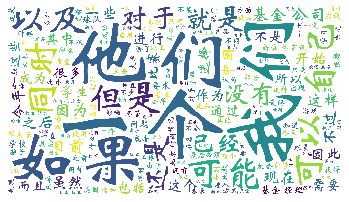

In [15]:
start = time.time()
my_wordcloud = WordCloud(background_color="white", width=1920, height=1080, font_path="C:\\Windows\\Fonts\\STXINWEI.TTF").generate(' '.join(train_corpus_cut))
end = time.time()
print('耗时：' + str(end-start) + 's')
plt.imshow(my_wordcloud)
plt.axis("off")
plt.show()

In [4]:
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), max_df=0.95, min_df=2)
x_train = vectorizer.fit_transform(train_corpus_cut)
x_valid = vectorizer.transform(valid_corpus_cut)

In [5]:
def train(clf, x_train, train_labels, info='nothing'):   
    start = time.time()
    try:
        clf.fit(x_train, train_labels)
    except:
        clf.fit(x_train.toarray(), train_labels)
    print(info + '训练结束')
    end=time.time()
    print('耗时：' + str(end-start) + 's')   
    
#朴素贝叶斯
NB_clf = GaussianNB()
#随机森林
RF_clf = RandomForestClassifier(n_estimators=100)
#支持向量机
SVM_clf = SVC(gamma='scale')
#K-近邻算法
KNN_clf = KNeighborsClassifier(algorithm='kd_tree')

clf_list = [NB_clf, RF_clf, SVM_clf, KNN_clf]
infos = ['朴素贝叶斯', '随机森林', '支持向量机', 'K-近邻']
for i, clf in enumerate(clf_list):
    train(clf, x_train, train_labels, infos[i])

朴素贝叶斯训练结束
耗时：22.467097759246826s
随机森林训练结束
耗时：85.51311135292053s
支持向量机训练结束
耗时：2803.4893748760223s
K-近邻训练结束
耗时：28.29146695137024s


In [6]:
def test(clf, x_valid, valid_labels):
    start = time.time()
    try:
        y_valid = clf.predict(x_valid)
    except:
        y_valid = clf.predict(x_valid.toarray())
    end = time.time()
    print(clf)
    print('正确率：' + str(sum(y_valid==valid_labels)/len(valid_labels)))
    print('耗时：' + str(end-start) + 's')
for clf in clf_list:
    test(clf, x_valid, valid_labels)

GaussianNB(priors=None, var_smoothing=1e-09)
正确率：0.98125
耗时：4.7312328815460205s
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
正确率：0.979
耗时：0.6837203502655029s
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
正确率：0.991
耗时：459.0428590774536s
KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_

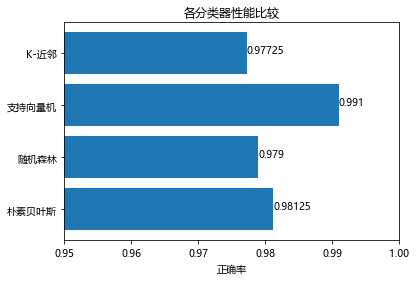

In [11]:
accs = [0.98125, 0.979, 0.991, 0.97725]
plt.rcParams['font.sans-serif'] =['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
plt.barh(range(4), accs)
plt.yticks(range(4), infos)
plt.title('各分类器性能比较')
plt.xlabel('正确率')
plt.xlim([0.95, 1])
for i, acc in enumerate(accs):
    plt.text(acc+0.00001, i, '%s'%acc)
plt.show()

In [8]:
emb = TSNE(n_components=2).fit_transform(x_train.toarray())

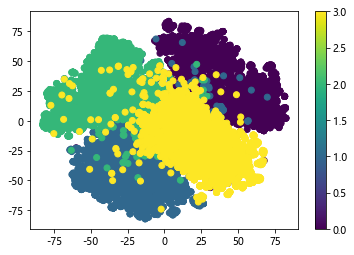

In [10]:
plt.scatter(emb[:, 0], emb[:, 1], c=train_labels)
plt.colorbar()
plt.show()

## 第二种变化
分类器固定为朴素贝叶斯，然后比较以下特征提取方法的性能：
* 使用分词，gram范围为(1,1)
* 使用分词，gram范围为(1,1)，使用百度停用词表
* 使用分词，gram范围为(1,2)
* 使用分词，gram范围为(1,2)，使用百度停用词表
* 不使用分词，gram范围为(1,2)
* 不使用分词，gram范围为(1,4)

以上六种方案的最大特征数都为2W

In [48]:
def get_accuracy(x_train, x_valid, train_labels, valid_labels):
    NB_clf = GaussianNB()
    NB_clf.fit(x_train.toarray(), train_labels)
    y_valid = NB_clf.predict(x_valid.toarray())
    print('正确率：' + str(sum(y_valid==valid_labels)/len(valid_labels))) 
    
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,1), max_df=0.95, min_df=2)
x_train = vectorizer.fit_transform(train_corpus_cut)
x_valid = vectorizer.transform(valid_corpus_cut)
get_accuracy(x_train, x_valid, train_labels, valid_labels)

正确率：0.9745


In [22]:
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), max_df=0.95, min_df=2, analyzer='char')
x_train = vectorizer.fit_transform(train_corpus)
x_valid = vectorizer.transform(valid_corpus)
get_accuracy(x_train, x_valid, train_labels, valid_labels)

In [27]:
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,4), max_df=0.95, min_df=2, analyzer='char')
x_train = vectorizer.fit_transform(train_corpus)
x_valid = vectorizer.transform(valid_corpus)
get_accuracy(x_train, x_valid, train_labels, valid_labels)

In [38]:
stop_words = []
with open(r'D:\textClassify\stopwords\百度停用词表.txt', encoding='utf-8') as f:
    for line in f:
        stop_words.append(line.replace('\n', ''))

In [49]:
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,1), max_df=0.95, min_df=2, stop_words=stop_words)
x_train = vectorizer.fit_transform(train_corpus_cut)
x_valid = vectorizer.transform(valid_corpus_cut)
get_accuracy(x_train, x_valid, train_labels, valid_labels)

c:\users\min\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'll', 'mon', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


正确率：0.974


In [50]:
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), max_df=0.95, min_df=2, stop_words=stop_words)
x_train = vectorizer.fit_transform(train_corpus_cut)
x_valid = vectorizer.transform(valid_corpus_cut)
get_accuracy(x_train, x_valid, train_labels, valid_labels)

c:\users\min\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'll', 'mon', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


正确率：0.98175


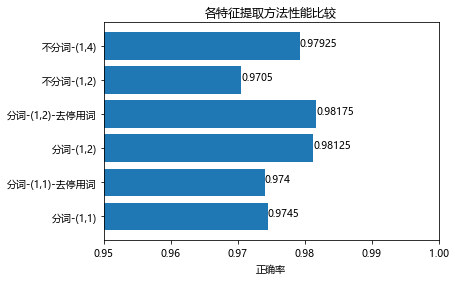

In [54]:
accs = [0.9745, 0.974, 0.98125, 0.98175, 0.9705, 0.97925]
infos = ['分词-(1,1)', '分词-(1,1)-去停用词', '分词-(1,2)', '分词-(1,2)-去停用词', '不分词-(1,2)', '不分词-(1,4)']
plt.barh(range(6), accs)
plt.yticks(range(6), infos)
plt.title('各特征提取方法性能比较')
plt.xlabel('正确率')
plt.xlim([0.95, 1])
for i, acc in enumerate(accs):
    plt.text(acc+0.00001, i, '%s'%acc)
plt.show()

## 使用深度学习方法

In [77]:
vocab_size = 20000
maxlen = 2000
embedding_dims = 128
batch_size = 64
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 100
num_class = 4

In [78]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_corpus_cut)
x_train = tokenizer.texts_to_sequences(train_corpus_cut)
x_valid = tokenizer.texts_to_sequences(valid_corpus_cut)
x_test = tokenizer.texts_to_sequences(test_corpus_cut)

In [79]:
x_train = pad_sequences(x_train, maxlen=maxlen)
x_valid = pad_sequences(x_valid, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)
y_train = to_categorical(train_labels)
y_valid = to_categorical(valid_labels)
y_test = to_categorical(test_labels)

In [80]:
def get_model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dims, input_length=maxlen))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(num_class))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary(line_length=125))
    return model

def train_and_predict(model):
    ES = EarlyStopping(patience=3, verbose=1, restore_best_weights=True)
    start = time.time()
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              callbacks=[ES],
              validation_data=(x_valid, y_valid))
    end = time.time()
    print('训练耗时：' + str(end-start) + 's')
    
    start = time.time()
    y_pred = model.predict(x_test)
    end = time.time()
    print('推断耗时：' + str(end-start) + 's')
    y_pred_cls = np.argmax(y_pred, 1)
    print('准确率：' + str(sum(y_pred_cls==test_labels)/len(test_labels)))

In [81]:
model = get_model()

Model: "sequential_7"
_____________________________________________________________________________________________________________________________
Layer (type)                                            Output Shape                                      Param #            
embedding_7 (Embedding)                                 (None, 2000, 128)                                 2560000            
_____________________________________________________________________________________________________________________________
dropout_13 (Dropout)                                    (None, 2000, 128)                                 0                  
_____________________________________________________________________________________________________________________________
conv1d_7 (Conv1D)                                       (None, 1998, 250)                                 96250              
________________________________________________________________________________________________

In [82]:
train_and_predict(model)

Train on 20000 samples, validate on 4000 samples
Epoch 1/100
20000/20000 [==============================] - 14s 712us/step - loss: 0.0542 - acc: 0.9840 - val_loss: 0.0303 - val_acc: 0.9915
Epoch 2/100
20000/20000 [==============================] - 14s 700us/step - loss: 0.0023 - acc: 0.9996 - val_loss: 0.0264 - val_acc: 0.9938
Epoch 3/100
20000/20000 [==============================] - 14s 701us/step - loss: 6.0481e-04 - acc: 1.0000 - val_loss: 0.0258 - val_acc: 0.9930
Epoch 4/100
20000/20000 [==============================] - 14s 700us/step - loss: 9.9974e-05 - acc: 1.0000 - val_loss: 0.0249 - val_acc: 0.9938
Epoch 5/100
20000/20000 [==============================] - 14s 702us/step - loss: 7.9571e-05 - acc: 1.0000 - val_loss: 0.0251 - val_acc: 0.9930
Epoch 6/100
20000/20000 [==============================] - 14s 707us/step - loss: 3.2500e-05 - acc: 1.0000 - val_loss: 0.0259 - val_acc: 0.9938
Epoch 7/100
20000/20000 [==============================] - 14s 698us/step - loss: 3.8517e-05 - 

使用字作为特征单元

In [91]:
vocab_size = 1000
kernel_size = 5
tokenizer = Tokenizer(num_words=vocab_size, char_level=True)
tokenizer.fit_on_texts(train_corpus)
x_train = tokenizer.texts_to_sequences(train_corpus)
x_valid = tokenizer.texts_to_sequences(valid_corpus)
x_test = tokenizer.texts_to_sequences(test_corpus)

In [92]:
x_train = pad_sequences(x_train, maxlen=maxlen)
x_valid = pad_sequences(x_valid, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [93]:
model = get_model()

Model: "sequential_10"
_____________________________________________________________________________________________________________________________
Layer (type)                                            Output Shape                                      Param #            
embedding_10 (Embedding)                                (None, 2000, 128)                                 128000             
_____________________________________________________________________________________________________________________________
dropout_19 (Dropout)                                    (None, 2000, 128)                                 0                  
_____________________________________________________________________________________________________________________________
conv1d_10 (Conv1D)                                      (None, 1996, 250)                                 160250             
_______________________________________________________________________________________________

In [94]:
train_and_predict(model)

Train on 20000 samples, validate on 4000 samples
Epoch 1/100
20000/20000 [==============================] - 14s 709us/step - loss: 0.0084 - acc: 0.9968 - val_loss: 0.0248 - val_acc: 0.9932
Epoch 2/100
20000/20000 [==============================] - 14s 698us/step - loss: 0.0063 - acc: 0.9982 - val_loss: 0.0291 - val_acc: 0.9928
Epoch 3/100
20000/20000 [==============================] - 14s 698us/step - loss: 0.0034 - acc: 0.9991 - val_loss: 0.0265 - val_acc: 0.9925
Epoch 4/100
20000/20000 [==============================] - 14s 696us/step - loss: 0.0014 - acc: 0.9996 - val_loss: 0.0364 - val_acc: 0.9928
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping
耗时：56.026411056518555s
耗时：0.6616532802581787s
准确率：0.99175


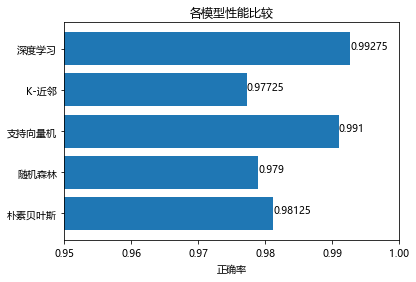

In [99]:
accs = [0.98125, 0.979, 0.991, 0.97725, 0.99275]
infos = ['朴素贝叶斯', '随机森林', '支持向量机', 'K-近邻', '深度学习']
plt.barh(range(5), accs)
plt.yticks(range(5), infos)
plt.title('各模型性能比较')
plt.xlabel('正确率')
plt.xlim([0.95, 1])
for i, acc in enumerate(accs):
    plt.text(acc+0.00001, i, '%s'%acc)
plt.show()

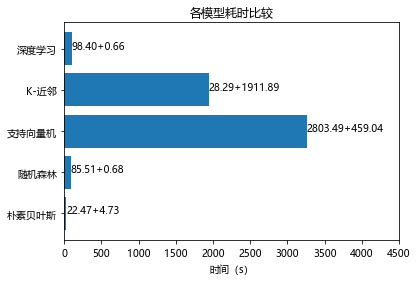

In [110]:
times = [22.47 + 4.73, 85.51 + 0.68, 2803.49 + 459.04, 28.29 + 1911.89, 98.40 + 0.66]
s_times = ['22.47+4.73', '85.51+0.68', '2803.49+459.04', '28.29+1911.89', '98.40+0.66']
infos = ['朴素贝叶斯', '随机森林', '支持向量机', 'K-近邻', '深度学习']
plt.barh(range(5), times)
plt.yticks(range(5), infos)
plt.title('各模型耗时比较')
plt.xlabel('时间（s）')
plt.xlim(0, 4500)
for i, t in enumerate(times):
    plt.text(t+0.00001, i, '%s'%s_times[i])
plt.show()